Loading Study1 dataset (Emotion-Antecedent Appraisal Checks:
EEG and EMG data sets for Novelty and Pleasantness)

In [94]:
import numpy as np
import mne
from mne.io import concatenate_raws, read_raw_fif
import mne.viz
from os import walk

In [97]:
#Get the files that belongs to participant 1
files = []
path = '../datasets/study1_eeg/'
for (dirpath, dirnames, filenames) in walk(path):
    new_names = [dirpath+f for f in filenames if ('P-01_' in f)]
    files.extend(new_names)
    break
print(len(files))

484


In [84]:
# Read the CSV file as a NumPy array
tmp = np.loadtxt(files[0], delimiter=',')
n_channels = tmp.shape[0]
n_times = tmp.shape[1]
participant_data = np.ndarray((len(files),n_channels,n_times))

for trial in range(1,len(files)):
    new_data = np.loadtxt(files[trial], delimiter=',')
    if trial == 1:
        print('n_channels, n_times: ' + str(new_data.shape))
    participant_data[trial] = new_data

print('Number of epochs: ' + str(participant_data.shape))

n_channels, n_times: (64, 384)
Number of epochs: (484, 64, 384)


In [85]:
#Extract event names from file names
epochs_events = []
for f in files:
    res = f.split('_')
    epochs_events.append(res[-2])

In [86]:
#Prepare the events for epochs object
unique_events = list(set(epochs_events))
unique_events_num = [i for i in range(len(unique_events))]
epoch_events_num = np.ndarray((len(epochs_events),3),int)

#Events parameter of epochs object is a numpyt ndarray which has dimensions as (n_epochs,3).
#It has the following structure for each epoch: (event_sample, previous_event_id, event_id)
for i in range(len(epochs_events)):
    for j in range(len(unique_events)):
        if epochs_events[i] == unique_events[j]:
            epoch_events_num[i,2] = unique_events_num[j]
            if i >0:
                epoch_events_num[i,1] = epoch_events_num[i-1,2]
            else:
                epoch_events_num[i,1] = unique_events_num[j]
        epoch_events_num[i,0] = i

67


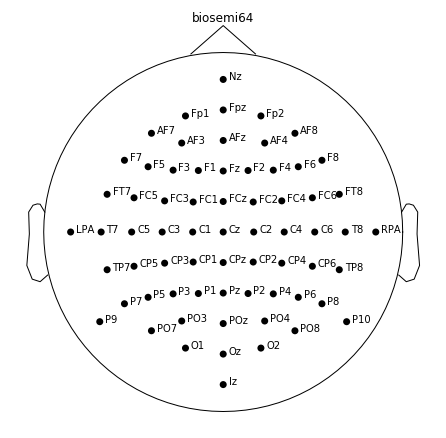

['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Nz', 'LPA', 'RPA']


In [87]:
# Get the positions of channels
# biosemi with 64 channels is the device that this eeg dataset is collected with

montage = mne.channels.read_montage('biosemi64') 
print(len(montage.ch_names))
montage.plot(show_names=True)
print(montage.ch_names)

In [88]:
# Remove the fiducial channels
n_channels = 64
fiducials = ['Nz', 'LPA', 'RPA']
ch_names = montage.ch_names
ch_names = [x for x in ch_names if x not in fiducials]
print(len(ch_names))
# Sampling rate
sfreq = 256  # Hz

64


In [89]:
%matplotlib inline
# Create the info structure for epochs object
epochs_info = mne.create_info(ch_names, sfreq, ch_types='eeg')

# Create the epochs object
print(participant_data.ndim)
epochs = mne.EpochsArray(data=participant_data, info=epochs_info, events=epoch_events_num)
epochs.set_montage(montage)

3
484 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<EpochsArray  |   484 events (all good), 0 - 1.49609 sec, baseline off, ~90.9 MB, data loaded,
 '0': 123
 '1': 126
 '2': 36
 '3': 133
 '4': 29
 '5': 37>

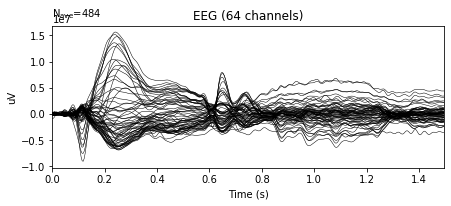

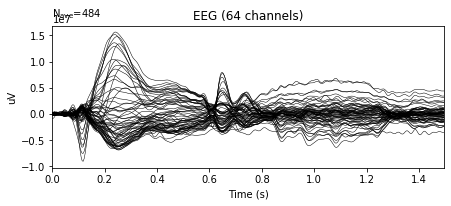

In [90]:
epochs.average().plot()

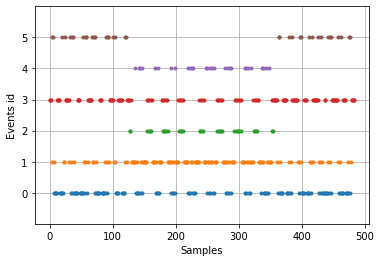

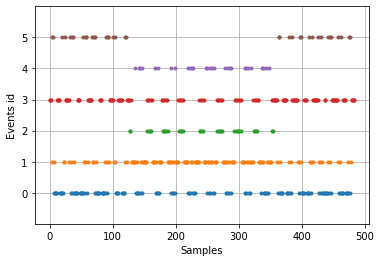

In [91]:
#plot events
mne.viz.plot_events(epochs.events)

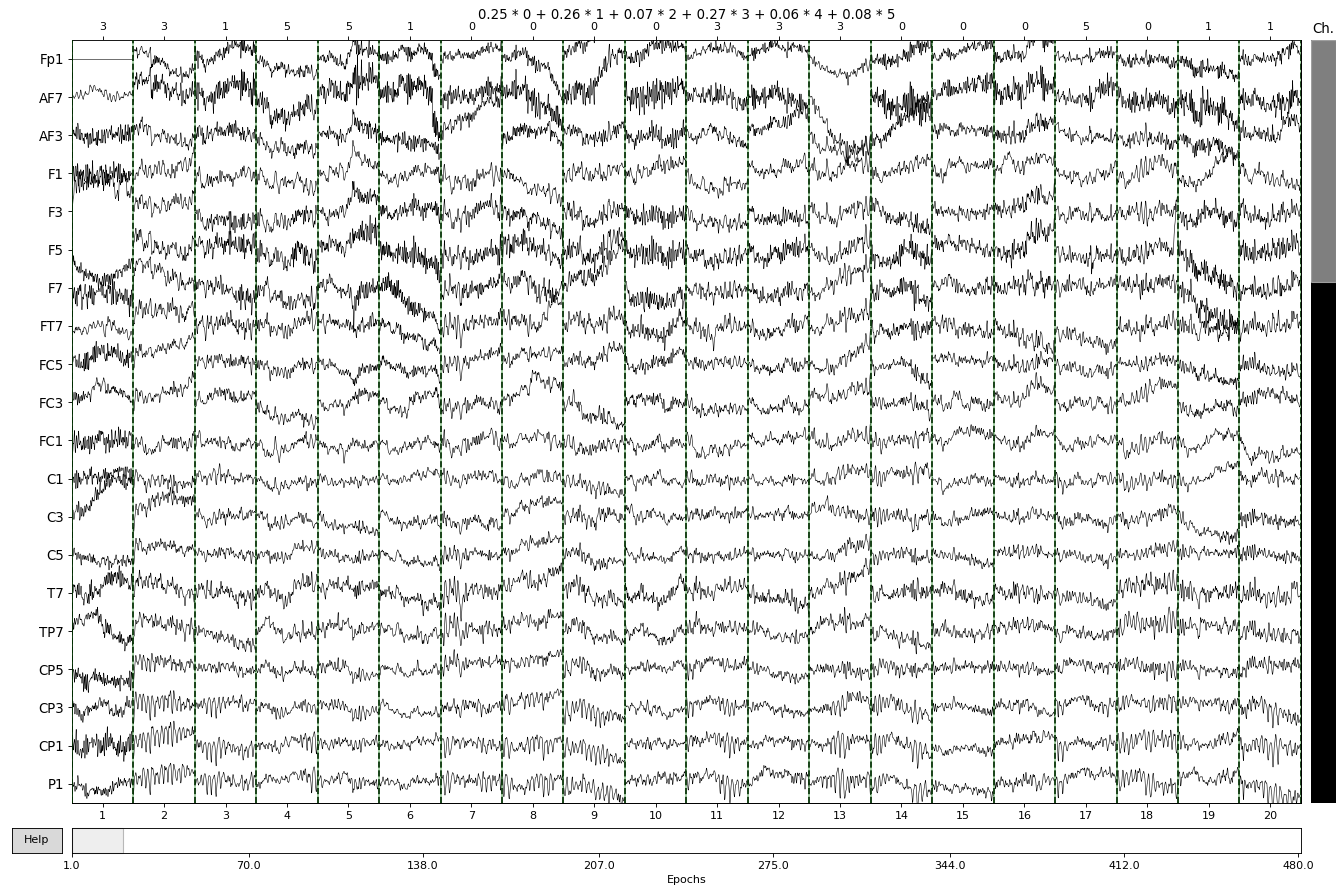

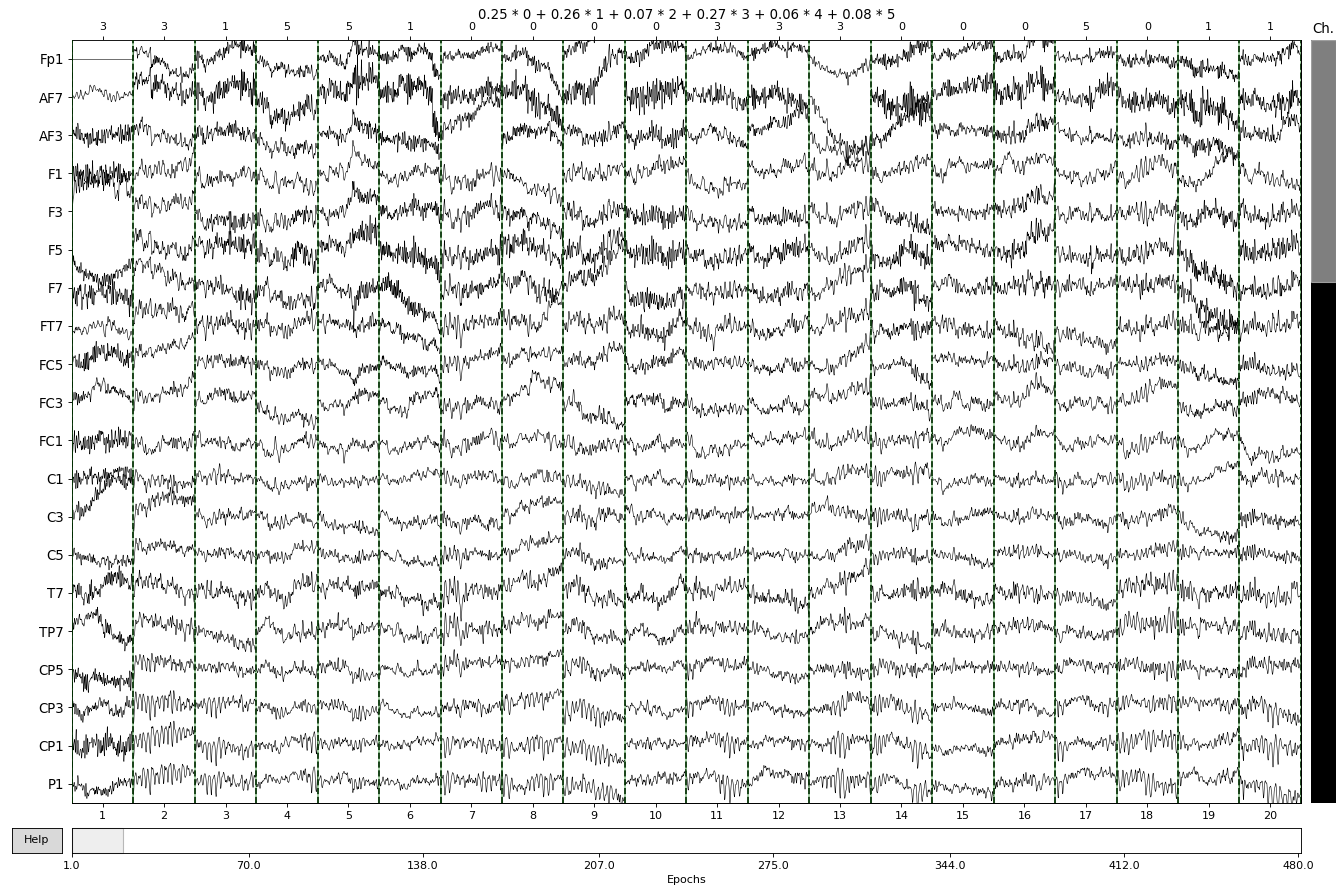

Dropped 0 epochs
Channels marked as bad: ['P7']


In [101]:
%matplotlib tk
mne.viz.plot_epochs(epochs, scalings='auto')
#epochs.plot(block=True)

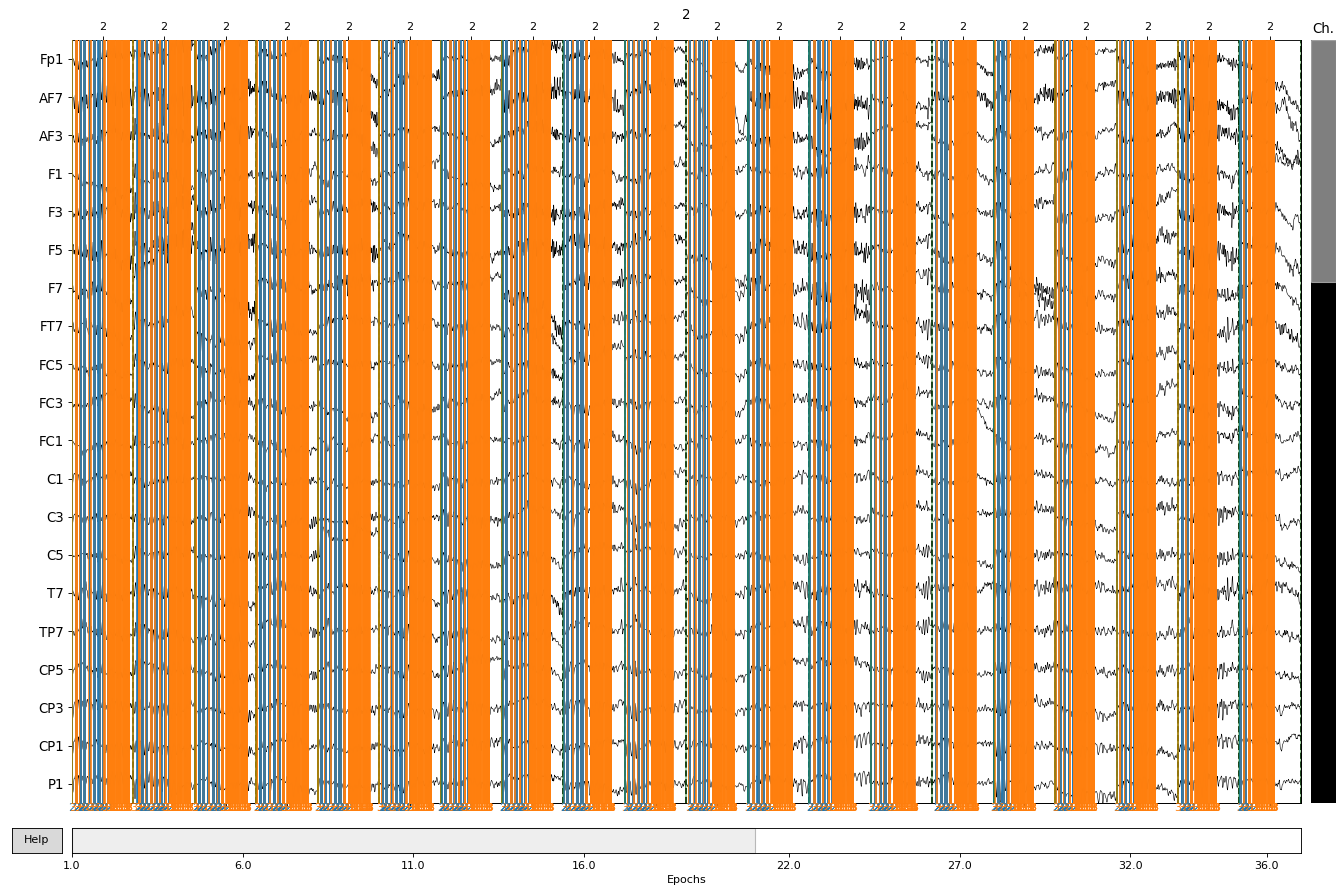

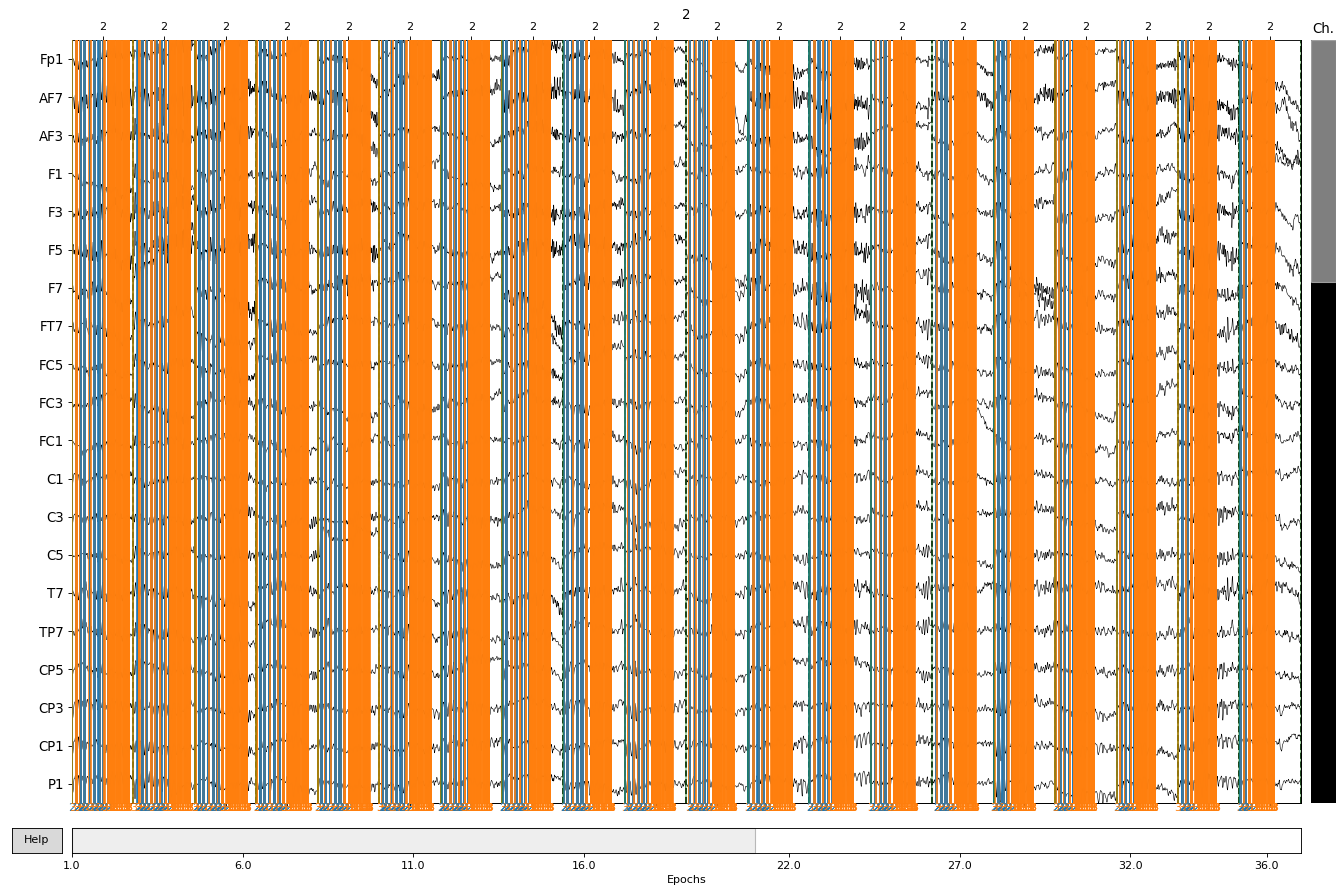

Dropped 0 epochs
Channels marked as bad: ['P7']


In [105]:
events = mne.pick_events(epochs.events, include=[2, 3])
epochs['2'].plot(events=events, scalings='auto')